Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# **Importing Skin Cancer Data**

**To do: Take necessary actions to read the data**

**Importing all the important libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.


In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

**Todo, create a code to visualize one instance of all the nine classes present in the dataset**

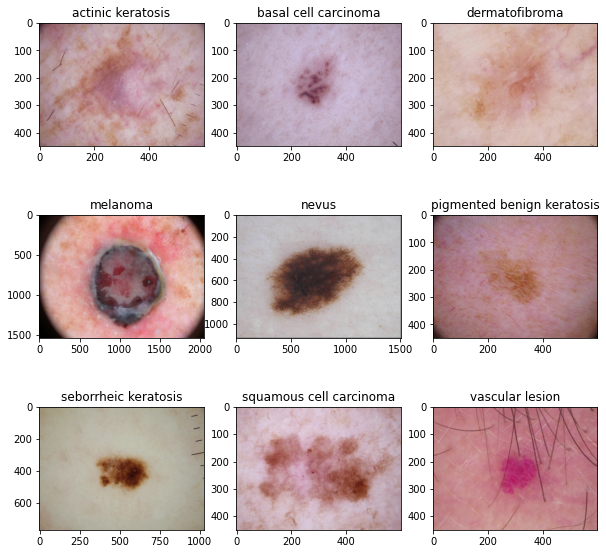

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)  

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). 

The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Create the model**
Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [11]:
num_classes = 9

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# model
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
# 1st conv layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation ='relu', input_shape = (img_height, img_width, batch_size)))
# 2rd conv layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 506944)            0         
                                                                 
 dense (Dense)               (None, 128)               64888960  
                                                        

**Train the model**

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 640s 2s/step - loss: 3.8679 - accuracy: 0.2801 - val_loss: 1.8230 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 5s 81ms/step - loss: 1.6277 - accuracy: 0.4364 - val_loss: 1.5247 - val_accuracy: 0.5414
Epoch 3/20
56/56 [==============================] - 5s 81ms/step - loss: 1.4491 - accuracy: 0.4939 - val_loss: 1.5494 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 5s 81ms/step - loss: 1.3613 - accuracy: 0.5218 - val_loss: 1.5529 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: 1.1445 - accuracy: 0.6200 - val_loss: 1.6786 - val_accuracy: 0.4966
Epoch 6/20
56/56 [==============================] - 5s 82ms/step - loss: 0.9817 - accuracy: 0.6646 - val_loss: 1.7589 - val_accuracy: 0.5213
Epoch 7/20
56/56 [==============================] - 5s 83ms/step - loss: 0.7911 - accuracy: 0.7288 - val_loss: 1.9639 - val_accuracy: 0.5213
Epoch 8/20
56/56 [======

**Visualizing training results**

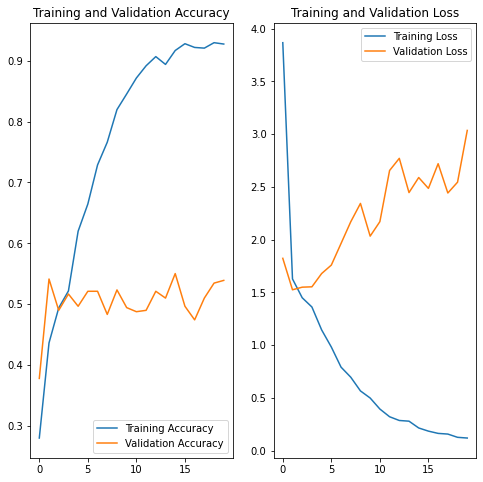

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit**

**Write your findings here**

**Finding for the first model**

1. The model is overfitting.
2. The accuracy of the model around 92%
3. Need more investigation to check the model is overfit or underfit.

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

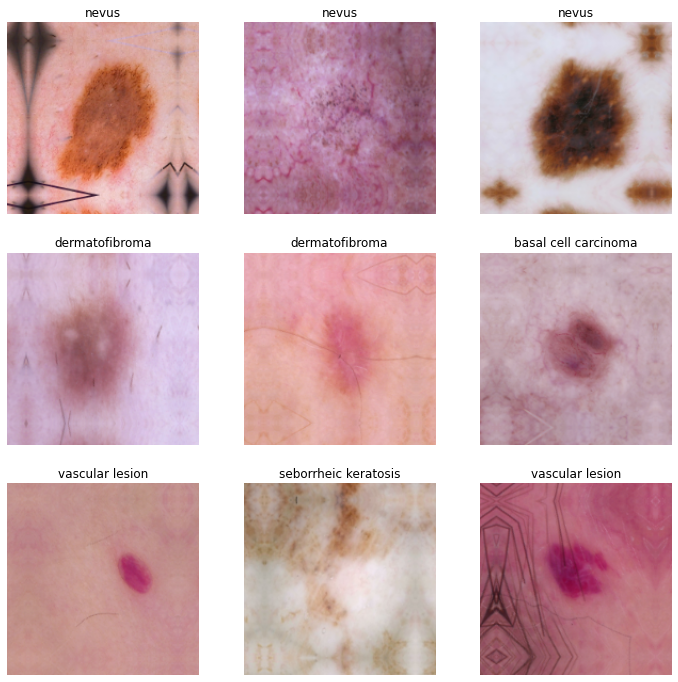

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12,12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Todo:**

**Create the model, compile and train the model**

In [40]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# model
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
# 1st conv layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation ='relu', input_shape = (img_height, img_width, batch_size)))
# 2rd conv layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

**Compiling the model**

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Training the model**

In [42]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 6s 87ms/step - loss: 3.9378 - accuracy: 0.2628 - val_loss: 1.7825 - val_accuracy: 0.3915
Epoch 2/20
56/56 [==============================] - 5s 85ms/step - loss: 1.7736 - accuracy: 0.3516 - val_loss: 1.6954 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 5s 85ms/step - loss: 1.7032 - accuracy: 0.3750 - val_loss: 1.6295 - val_accuracy: 0.4072
Epoch 4/20
56/56 [==============================] - 5s 85ms/step - loss: 1.5916 - accuracy: 0.4230 - val_loss: 1.7224 - val_accuracy: 0.3870
Epoch 5/20
56/56 [==============================] - 5s 86ms/step - loss: 1.5963 - accuracy: 0.4252 - val_loss: 1.5553 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 5s 86ms/step - loss: 1.5284 - accuracy: 0.4654 - val_loss: 1.4808 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 5s 86ms/step - loss: 1.4510 - accuracy: 0.4939 - val_loss: 1.4381 - val_accuracy: 0.5145
Epoch 8/20
56/56 [======

**Visualizing the results**

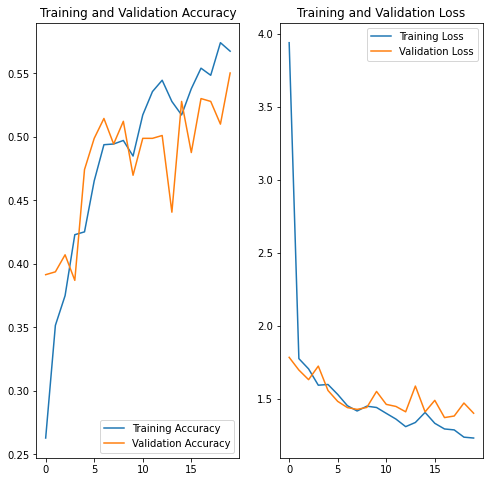

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo:** Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding for the second model**

1. Compare to the first model no improvement in accuracy
2. But overfitting problem has solved due to data augmentation

**Todo:** Find the distribution of classes in the training dataset.

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [44]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/datasets/CNN_assignmen...,actinic keratosis
1,/content/gdrive/MyDrive/datasets/CNN_assignmen...,actinic keratosis
2,/content/gdrive/MyDrive/datasets/CNN_assignmen...,actinic keratosis
3,/content/gdrive/MyDrive/datasets/CNN_assignmen...,actinic keratosis
4,/content/gdrive/MyDrive/datasets/CNN_assignmen...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/datasets/CNN_assignmen...,vascular lesion
2235,/content/gdrive/MyDrive/datasets/CNN_assignmen...,vascular lesion
2236,/content/gdrive/MyDrive/datasets/CNN_assignmen...,vascular lesion
2237,/content/gdrive/MyDrive/datasets/CNN_assignmen...,vascular lesion


**Todo:** Write your findings here:

-Which class has the least number of samples?

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

-Which classes dominate the data in terms proportionate number of samples?

In [68]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

**Todo:** Rectify the class imbalance

**Context:** You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [45]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [46]:
path_to_training_dataset="/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DF405FC10>: 100%|██████████| 500/500 [00:21<00:00, 22.96 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DFD13B390>: 100%|██████████| 500/500 [00:22<00:00, 22.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0D270B5910>: 100%|██████████| 500/500 [00:20<00:00, 23.87 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F0DF0085610>: 100%|██████████| 500/500 [01:21<00:00,  6.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DF0494710>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DF468BA10>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F0DF056F290>: 100%|██████████| 500/500 [00:40<00:00, 12.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DFE71CC90>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0DFEAEE190>: 100%|██████████| 500/500 [00:18<00:00, 27.55 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [47]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [48]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_0b4b8169-6d59-4846-916d-9c481b502dc6.jpg',
 '/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_16dc7017-fa95-431d-94f7-0bd48d20d9ab.jpg',
 '/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_c33546a1-037a-4555-acd7-c5f77b470cb1.jpg',
 '/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_b09edd12-bbc9-4c66-8cc7-f0515dc90ae9.jpg',
 '/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The Internati

In [49]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [50]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [51]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [52]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Todo: Train the model on the data created using Augmentor**

In [53]:
batch_size = 32
img_height = 180
img_width = 180

**Todo:** Create a training dataset

In [54]:
data_dir_train="/content/gdrive/MyDrive/datasets/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Todo:** Create a validation dataset

In [56]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Todo:** Create your model (make sure to include normalization)

In [57]:
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
# 1st conv layer
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation ='relu', input_shape = (img_height, img_width, batch_size)))
# 2rd conv layer
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

**Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Todo:** Train your model

In [60]:
#epochs = 30
## Your code goes here, use 50 epochs.
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 32s 186ms/step - loss: 0.0813 - accuracy: 0.9687 - val_loss: 1.8518 - val_accuracy: 0.6852
Epoch 2/50
169/169 [==============================] - 32s 186ms/step - loss: 0.0887 - accuracy: 0.9653 - val_loss: 1.8636 - val_accuracy: 0.6748
Epoch 3/50
169/169 [==============================] - 33s 193ms/step - loss: 0.0974 - accuracy: 0.9655 - val_loss: 1.8890 - val_accuracy: 0.7105
Epoch 4/50
169/169 [==============================] - 32s 185ms/step - loss: 0.0794 - accuracy: 0.9688 - val_loss: 1.6890 - val_accuracy: 0.6897
Epoch 5/50
169/169 [==============================] - 32s 186ms/step - loss: 0.0854 - accuracy: 0.9681 - val_loss: 1.9845 - val_accuracy: 0.7120
Epoch 6/50
169/169 [==============================] - 32s 186ms/step - loss: 0.1155 - accuracy: 0.9601 - val_loss: 1.9885 - val_accuracy: 0.7023
Epoch 7/50
169/169 [==============================] - 32s 185ms/step - loss: 0.0804 - accuracy: 0.9703 - val_loss: 2.0072 - val_ac

**Todo:** Visualize the model results

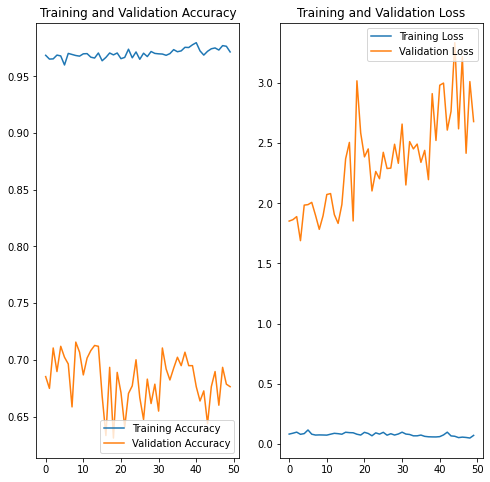

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo:** Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1. Accuracy increase, but model is still overfit.
2. Need to add more layers and droupout.
3. Required more tunning of this model.